# Prepare the data

In [1]:
# Create the directory structure and download the data from Kaggle
# !mkdir -p ~/DataspellProjects/kaggle/digit-recognizer/data
# !cd ~/DataspellProjects/kaggle/digit-recognizer/data
# !kaggle competitions download -c digit-recognizer
# !unzip digit-recognizer.zip

In [2]:
# import necessary libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import torch
from torch import Generator
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms

from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

In [3]:
train = pd.read_csv('data/train.csv')

In [4]:
train.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [5]:
print('number of training samples is:', len(train))

number of training samples is: 42000


In [6]:
# x = i * 28 + j, where i is the row and j is the column
# transfer the data to a 28x28 tensor matrix
train_x = train.iloc[:, 1:].values.astype(float).reshape(-1, 1, 28, 28)
train_y = train.iloc[:, 0].values
train_x.shape

(42000, 1, 28, 28)

In [7]:
train.max().max()

255

In [8]:
# Create image dataset for preprocessing and augmentation
class ImageDataset(Dataset):
    def __init__(self, ids, X_transform=None, y_transform=None):
        self.ids=ids
        self.X_transform=X_transform
        self.y_transform=y_transform

    def __len__(self):
        return len(self.ids)

    def __getitem__(self, index):
        image = self.ids.iloc[index, 1:].values.astype('float32').reshape(1, 28, 28)
        if self.X_transform:
            image = self.X_transform(image)

        label = self.ids.iloc[index, 0]
        if self.y_transform:
            label = self.y_transform(label)

        return image, label

In [9]:
def imageDataLoader(
        raw_data,
        batch_size=64,
        train_test_split=0.3,
        seed=0,
        X_transform=None,
        y_transform=None
):

    dataset = ImageDataset(raw_data, X_transform=X_transform, y_transform=y_transform)
    train_set, val_set = random_split(
        dataset,
        [(1-train_test_split), train_test_split],
        generator=Generator().manual_seed(seed)
    )

    #DataLoaders
    train_loader = DataLoader(dataset=train_set, batch_size=batch_size, shuffle=True)
    val_loader= DataLoader(dataset=val_set, batch_size=batch_size, shuffle=True)

    return train_loader, val_loader

In [10]:
X_transform = transforms.Compose([
    # transforms.ToTensor(),
    transforms.RandomRotation((-10.0, 10.0)),
    transforms.RandomSolarize(p=0.5, threshold=0.5),
    transforms.RandomAffine(degrees=0, translate=(0.1,0.1)),
])

y_transform = transforms.Compose([
    transforms.ToTensor(),
])

In [11]:
train_loader, val_loader = imageDataLoader(
    train,
    batch_size=64,
    train_test_split=0.3,
    seed=0,
    # X_transform=X_transform,
    # y_transform=y_transform
)

In [12]:
for X, y in train_loader:
    print(X.dtype)
    print(y.shape)
    print(y.dtype)
    break

torch.float32
torch.Size([64])
torch.int64


Feature batch shape: torch.Size([64, 1, 28, 28])
Labels batch shape: torch.Size([64])


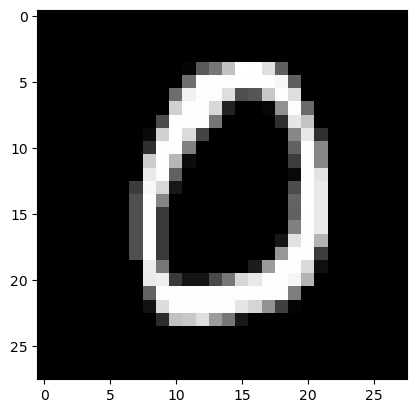

Label: 0


In [13]:
train_features, train_labels = next(iter(train_loader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
img = train_features[0].squeeze()
label = train_labels[0]
plt.imshow(img, cmap="gray")
plt.show()
print(f"Label: {label}")

# Build the model

In [14]:
import torch.nn as nn
import torch.nn.functional as F

In [15]:
# Define the model: MLP
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.dropout1 = nn.Dropout2d(0.25)
        self.dropout2 = nn.Dropout2d(0.5)
        self.fc1 = nn.Linear(1600, 128)
        self.fc2 = nn.Linear(128, 10)


    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(F.max_pool2d(x, 2))
        x = self.conv2(x)
        x = F.relu(F.max_pool2d(x, 2))
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = self.dropout2(x)
        x = F.relu(self.fc2(x))
        return x

# Train the model

In [16]:
import torch.optim as optim
from torch.optim.lr_scheduler import ExponentialLR

In [17]:
!mkdir -p ~/DataspellProjects/kaggle/digit-recognizer/models
!mkdir -p ~/DataspellProjects/kaggle/digit-recognizer/tb_logs

In [18]:
from torch.utils.tensorboard import SummaryWriter

# default `log_dir` is "runs" - we'll be more specific here
writer = SummaryWriter('tb_logs/MLP')

In [19]:
model = CNN()
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

scheduler = ExponentialLR(optimizer, gamma=0.9)

In [20]:
device = torch.device("mps" if torch.has_mps else "cpu")
# device = torch.device("cpu")
epochs = 10
for epoch in tqdm(range(epochs)):
    train_loss = 0
    train_acc = 0
    val_loss = 0
    val_acc = 0
    best_val_acc = 0

    model.to(device) # set the model to the device
    model.train() # set the model to training mode
    # training loop
    for X, y in train_loader:
        X = X.to(device)
        y = y.to(device)

        optimizer.zero_grad()
        output = model(X)

        loss = criterion(output, y)
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * X.size(0)
        train_acc += (output.argmax(1) == y).cpu().type(torch.float).sum()

    writer.add_scalar('training loss',
                      train_loss / len(train_loader.dataset),
                      epoch+1)

    writer.add_scalar('training accuracy',
                      train_acc / len(train_loader.dataset),
                      epoch+1)

    model.eval()
    with torch.no_grad(): # set the model to evaluation mode
        # validation loop
        for X, y in val_loader:
            X = X.to(device)
            y = y.to(device)
            output = model(X)
            loss = criterion(output, y)
            val_loss += loss.item() * X.size(0)
            val_acc += (output.argmax(1) == y).cpu().type(torch.float).sum()

    writer.add_scalar('validation loss',
                      val_loss / len(val_loader.dataset),
                      epoch+1)

    writer.add_scalar('validation accuracy',
                      val_acc / len(val_loader.dataset),
                      epoch+1)

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), 'models/cnn_model.pt')

    train_loss = train_loss / len(train_loader.dataset)
    train_acc = train_acc / len(train_loader.dataset)
    val_loss = val_loss / len(val_loader.dataset)
    val_acc = val_acc / len(val_loader.dataset)
    print(f'Epoch: {epoch + 1}: Training Loss: {train_loss:.4f} \tValidation Loss: {val_loss:.4f} \tTraining Accuracy: {train_acc:.4f} \tValidation Accuracy: {val_acc:.4f}')

    scheduler.step()

writer.close()

  0%|          | 0/10 [00:00<?, ?it/s]

/Users/xiaoziqi/opt/anaconda3/envs/pytorch/lib/python3.10/site-packages/torch/nn/functional.py:1331: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


Epoch: 1: Training Loss: 0.7288 	Validation Loss: 0.1331 	Training Accuracy: 0.8084 	Validation Accuracy: 0.9620
Epoch: 2: Training Loss: 0.2143 	Validation Loss: 0.1030 	Training Accuracy: 0.9393 	Validation Accuracy: 0.9713
Epoch: 3: Training Loss: 0.1565 	Validation Loss: 0.0784 	Training Accuracy: 0.9551 	Validation Accuracy: 0.9797
Epoch: 4: Training Loss: 0.1282 	Validation Loss: 0.0792 	Training Accuracy: 0.9622 	Validation Accuracy: 0.9790
Epoch: 5: Training Loss: 0.1080 	Validation Loss: 0.0657 	Training Accuracy: 0.9677 	Validation Accuracy: 0.9813
Epoch: 6: Training Loss: 0.1005 	Validation Loss: 0.0664 	Training Accuracy: 0.9706 	Validation Accuracy: 0.9817
Epoch: 7: Training Loss: 0.0875 	Validation Loss: 0.0709 	Training Accuracy: 0.9736 	Validation Accuracy: 0.9825
Epoch: 8: Training Loss: 0.0766 	Validation Loss: 0.0643 	Training Accuracy: 0.9770 	Validation Accuracy: 0.9837
Epoch: 9: Training Loss: 0.0663 	Validation Loss: 0.0637 	Training Accuracy: 0.9796 	Validation 

In [21]:
# %load_ext tensorboard

In [22]:
# %tensorboard --logdir=tb_logs

# Test the model

In [23]:
test = pd.read_csv('data/test.csv')

In [24]:
test = test.values.reshape(-1, 28, 28)
test = torch.from_numpy(test)
test = test.unsqueeze(1)
test = test.type(torch.float)

In [25]:
model = CNN()
model.load_state_dict(torch.load('models/cnn_model.pt'))
model.eval()

CNN(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (dropout1): Dropout2d(p=0.25, inplace=False)
  (dropout2): Dropout2d(p=0.5, inplace=False)
  (fc1): Linear(in_features=1600, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)

In [26]:
device = torch.device("mps" if torch.has_mps else "cpu")
# device = torch.device("cpu")
model.to(device)

CNN(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (dropout1): Dropout2d(p=0.25, inplace=False)
  (dropout2): Dropout2d(p=0.5, inplace=False)
  (fc1): Linear(in_features=1600, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)

In [27]:
test = test.to(device)
output = model(test)
output = output.argmax(1).cpu().numpy()

/Users/xiaoziqi/opt/anaconda3/envs/pytorch/lib/python3.10/site-packages/torch/nn/functional.py:1331: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


In [28]:
output

array([2, 0, 9, ..., 3, 9, 2])

In [29]:
!mkdir -p ~/DataspellProjects/kaggle/digit-recognizer/submissions

In [30]:
submission = pd.DataFrame({'ImageId': range(1, len(output)+1), 'Label': output})
submission.to_csv('submissions/cnn_submission.csv', index=False)

In [31]:
# make submission
!kaggle competitions submit -c digit-recognizer -f ~/DataspellProjects/kaggle/digit-recognizer/submissions/cnn_submission.csv -m "CNN submission"

100%|████████████████████████████████████████| 208k/208k [00:03<00:00, 55.0kB/s]
Successfully submitted to Digit Recognizer